# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k


Data is available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/`
Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

## Load data

Download all the multiome data using the following command

# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import pyranges as pr
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [6]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [7]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

# Load data

In [8]:
data_dir = '/fh/fast/setty_m/grp/lab-datasets/bonemarrow-tcell-dep-multiome/cr-arc-results/'

In [9]:
#combine replicates

samples = ['rep1', 'rep2']
rna_ad_dict, atac_ad_dict = dict(), dict()

for r in samples:
    comb_ad = sc.read_10x_h5(data_dir + r+ '/filtered_feature_bc_matrix.h5', gex_only=False)
    comb_ad.obs_names = 'tcell-dep-multiome_' + r + "#" + comb_ad.obs_names
    rna_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types']=='Gene Expression']
    rna_ad_dict[r].var_names_make_unique()
    rna_ad_dict[r].obs['sample']= r
    
    atac_ad_dict[r] = comb_ad[:, comb_ad.var['feature_types'] == 'Peaks']
    atac_ad_dict[r].var_names_make_unique()
    

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
sample_cells = dict()
for sample in samples:
    sample_cells[sample] = rna_ad_dict[sample].obs_names


In [11]:
samples

['rep1', 'rep2']

In [12]:
#Per barcode metrics
bc_metrics_dict = dict ()
for sample in samples:
    bc_metrics_dict[sample] = pd.read_csv(data_dir + sample +'/per_barcode_metrics.csv', index_col = 0)
    bc_metrics_dict[sample].index = 'tcell_dep_multiome_' + sample + "#" +bc_metrics_dict[sample].index
    bc_metrics_dict[sample] = bc_metrics_dict[sample].loc[rna_ad_dict[sample].obs_names]
    
#FRIP
    bc_metrics_dict[sample]['FRIP'] = bc_metrics_dict[sample]['atac_peak_region_fragments']/bc_metrics_dict[sample]['atac_fragments']

In [13]:
# Barcode metrics
#bc_metrics = pd.read_csv(data_dir + '/pbmc_unsorted_10k_per_barcode_metrics.csv', index_col=0)
#bc_metrics.index = 'pbmc_multiome' + '#' +bc_metrics.index 

# FRIP
#bc_metrics['FRIP'] = bc_metrics['atac_peak_region_fragments']/bc_metrics['atac_fragments']

# Preprocess

This section follows the preprocessing steps of the single-cell RNA-seq analysis 

In [14]:
for r in samples:
    rna_ad = rna_ad_dict[r]
    rna_ad.var['mt'] = rna_ad.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(rna_ad, qc_vars = ['mt'], inplace = True, percent_top = None, log1p =False)

In [15]:
for r in samples: 
    atac_ad = atac_ad_dict[r]
    sc.pp.calculate_qc_metrics(atac_ad, inplace = True, percent_top = None, log1p = False)

## QC

### Filter cell based on RNA

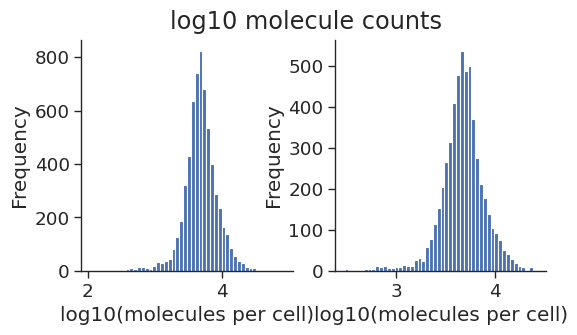

In [16]:
#plt.figure()
#ax = plt.gca()
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_xlabel('log10(molecules per cell)')
    ax.set_ylabel('Frequency')
plt.suptitle('log10 molecule counts')
sns.despine()

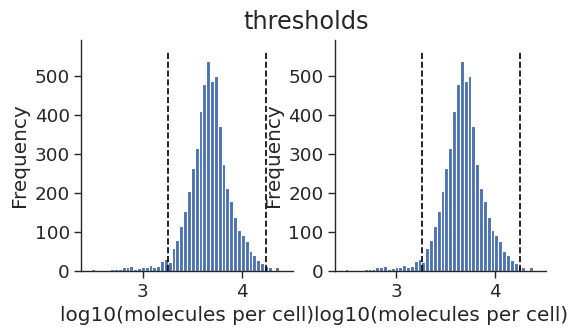

In [17]:
# Manually adjust the threshold percentage depending on the dataset
# Doublet detection (Eg: scrublet) will work better for higher molecule count cells

fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    THRESHOLDS = np.log10(np.percentile((rna_ad.obs['total_counts']), [3.5, 99.5]))
    ax.hist(np.log10(rna_ad.obs['total_counts']), 50)
    ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
    ax.set_xlabel('log10(molecules per cell)')
    ax.set_ylabel('Frequency')
plt.suptitle('thresholds')
sns.despine()

In [18]:
# Filter cells 
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    cells = rna_ad.obs_names
    
    # Filter
    THRESHOLDS = np.percentile((rna_ad.obs['total_counts']), [2.5, 99.5])
    sample_cells[sample] = cells[(rna_ad.obs['total_counts'][cells] > THRESHOLDS[0]) & \
        (rna_ad.obs['total_counts'][cells] < THRESHOLDS[1])]

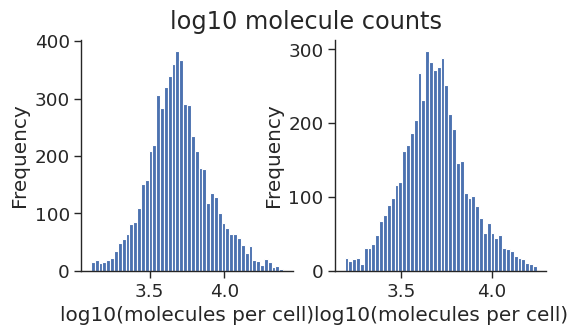

In [19]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    rna_ad = rna_ad_dict[sample]
    cells = rna_ad.obs_names
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_xlabel('log10(molecules per cell)')
    ax.set_ylabel('Frequency')
plt.suptitle('log10 molecule counts')
sns.despine()

### Filter based on ATAC

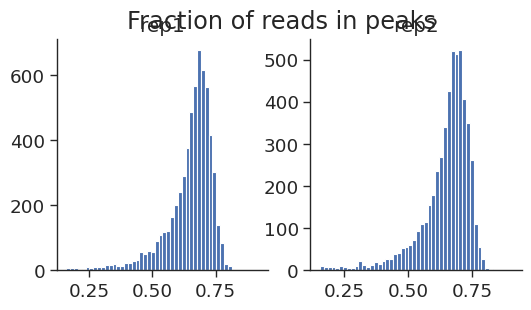

In [20]:
## CAUTION: CellRanger peak calling is unreliable and we only use it here to filter cells with low 
##          fraction of reads in peaks. This is ok since CellRanger peak caller dramatically over estimates 
##          the peak widths. We might incur some false negatives, but thats an acceptable error for filtering   
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip(samples, fig):
    ax.hist(bc_metrics_dict[sample]['FRIP'][sample_cells[sample]], 50)
    ax.set_title(sample)
    
    
plt.suptitle('Fraction of reads in peaks')

sns.despine()

In [21]:
THRESHOLD = 0.4
for sample in samples: sample_cells[sample] = sample_cells[sample][bc_metrics_dict[sample]['FRIP'][sample_cells[sample]] > THRESHOLD]

Text(0.5, 0.98, 'log10 molecule counts')

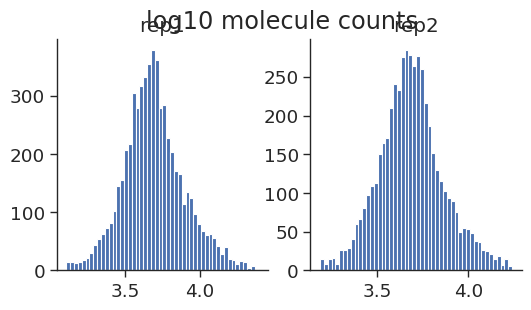

In [22]:
fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    ax.hist(np.log10(rna_ad.obs['total_counts'][sample_cells[sample]]), 50)
    ax.set_title(sample)
sns.despine()
plt.suptitle('log10 molecule counts')

### Filter based on mitochondria

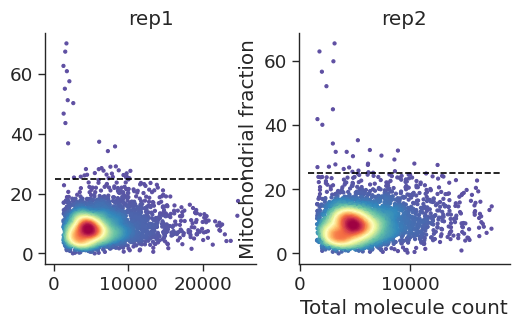

In [23]:
    
MITO_THRESHOLD = 25

fig = palantir.plot.FigureGrid(len(samples), 5)
for sample, ax in zip (samples, fig):
    rna_ad = rna_ad_dict[sample]
    x,y,dens = palantir.plot.density_2d(rna_ad.obs['total_counts'][sample_cells[sample]], 
               rna_ad.obs['pct_counts_mt'][sample_cells[sample]])
    ax.scatter(x, y, c=dens, s=5)
    ax.hlines(MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')
    plt.xlabel('Total molecule count')
    plt.ylabel('Mitochondrial fraction')
    ax.set_title(sample)
sns.despine()


In [24]:
for sample in samples:
    cells = sample_cells[sample]
    sample_cells[sample] = cells[rna_ad_dict[sample].obs['pct_counts_mt'][cells] < MITO_THRESHOLD]

In [26]:
sample = samples[0]
ad = rna_ad_dict[sample][sample_cells[sample]]
for sample in samples[1:]:
    ad = ad.concatenate(rna_ad_dict[sample][sample_cells[sample]], 
                            index_unique=None, batch_key='batch')
ad

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 10960 × 36601
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1'

In [27]:
ad.var = pd.DataFrame(index=ad.var_names)

In [28]:
raw_ad = ad.copy()

In [29]:
# Filter genes 
sc.pp.filter_genes(ad, min_cells=50)

In [30]:
import scrublet as scr

In [31]:
doublet_scores = pd.Series(0.0, index = ad.obs_names)
for sample in samples:
    cells = ad.obs_names[ad.obs['sample'] == sample]
    scrub = scr.Scrublet(raw_ad[cells, :].X)
    scores, predicted_doublets = scrub.scrub_doublets()
    doublet_scores[cells] = scores
ad.obs['DoubletScores'] = doublet_scores.values

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 36.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.3%
Elapsed time: 8.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 44.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.4%
Elapsed time: 5.9 seconds


## Analysis

In [32]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [33]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=2500)
ad

AnnData object with n_obs × n_vars = 10960 × 17127
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [34]:
# PCA
sc.pp.pca(ad, use_highly_variable=True, n_comps=50)
ad
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance

AnnData object with n_obs × n_vars = 10960 × 17127
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [53]:
ad.obsm['X_pca']

array([[-14.114838  ,  -1.9502962 ,  -1.3123335 , ...,   0.19105344,
          1.5276825 ,   0.7715937 ],
       [-17.06581   ,  -2.6871223 ,  -1.2002969 , ...,  -4.267732  ,
          2.0256257 ,  -3.6448226 ],
       [-14.335693  ,   0.63428867,   0.62069386, ...,  -1.7736604 ,
          1.285805  ,  -2.621341  ],
       ...,
       [ 15.84891   , -17.3221    ,  29.319012  , ...,  -0.5166932 ,
          0.9480823 ,  -4.3145037 ],
       [  9.273336  , -13.366569  ,  25.049965  , ...,   1.5700257 ,
         -0.07558459,  -0.8902777 ],
       [ 14.940606  , -13.987827  ,  26.24882   , ...,   3.0167854 ,
          3.2977242 ,   3.5961175 ]], dtype=float32)

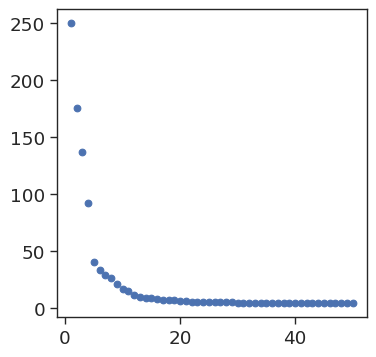

In [54]:
plt.scatter(x = range(1, 51), y = ad.uns['pca']['variance'])

array([-0.0206604 , -0.01965332,  0.01299286, -0.00622559, -0.00531006,
       -0.02217102,  0.0567627 , -0.02294922,  0.02685547, -0.00830078,
        0.00033569, -0.00984192,  0.01621246,  0.01420593, -0.02113342,
        0.01759338,  0.01997375,  0.00479126,  0.01272583,  0.00139618,
       -0.01655579, -0.02983093, -0.01374817,  0.0107193 ,  0.0408783 ,
        0.00067139,  0.02145386, -0.00343323, -0.01008606, -0.05727386,
       -0.01436234,  0.00524902,  0.00045776,  0.00537109, -0.0124054 ,
       -0.03738022, -0.02716064,  0.05264282, -0.00513077,  0.0092392 ,
        0.03353882, -0.02159119, -0.01794434, -0.02474976,  0.02949524,
       -0.00016022,  0.00426865, -0.01069641,  0.00144958, -0.03513336],
      dtype=float32)

In [55]:
# UMAP and Leiden - requires the computation of nearest neighbors
sc.pp.neighbors(ad, use_rep='X_pca')
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

AnnData object with n_obs × n_vars = 10960 × 17127
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [56]:
# Diffusion maps 
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 10960 × 17127
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [57]:
# Phenograph 
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.2651379108428955 seconds
Jaccard graph constructed in 2.5563528537750244 seconds
Wrote graph to binary file in 0.2275385856628418 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.896508
After 5 runs, maximum modularity is Q = 0.897616
Louvain completed 25 runs in 6.83392333984375 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 14.986819505691528 seconds


In [58]:
# Imputation
ad.obsm['MAGIC_imputed_data'] = impute_data(dm_res, ad)

# Visualize results

In [59]:
ad.obs['log_n_counts'] = np.log10(ad.obs['total_counts'])

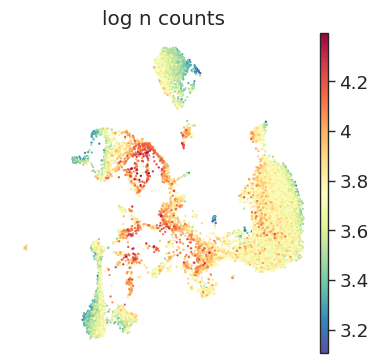

In [60]:
sc.pl.scatter(ad, basis='umap', color='log_n_counts', frameon=False)

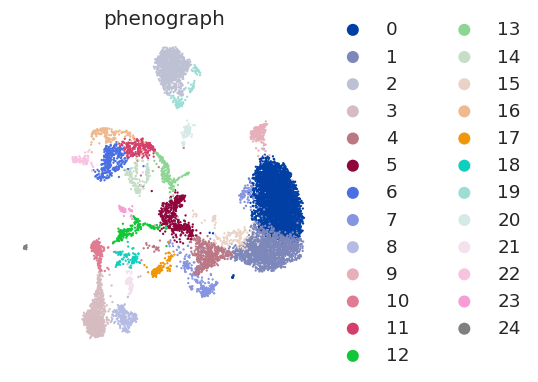

In [130]:
sc.pl.scatter(ad, basis='umap', color=['phenograph'],frameon=False)

# Celltype annotation

In [62]:
genes = pd.Series([
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14",  #Monocytes
    "CD3D", "CD8A", 'CD4', #TCells,
    'FCGR3A', #'CD16', 
     'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD19',  'IRF8', 'IRF4',
    'ITGA2B', # CD41,
    'NCAM1', # CD56,
    'CCR7' # Memory T cell
])
genes = genes[genes.isin(ad.var_names)]

In [72]:
markers = {'HSPC': ['CD34'], 
               'CLP/Bcells': ["CD79B", "EBF1", "PAX5"],
               'B cells': ["CD19"], 
               'Ery': ['GATA1', 'GATA2'], 
               'DC': ['IRF4', 'IRF8'],
               'Mono': ['MPO'],
               'Megakaryocyte': ['ITGA2B'], 
              }

categories: 0, 1, 2, etc.
var_group_labels: HSPC, CLP/Bcells, B cells, etc.


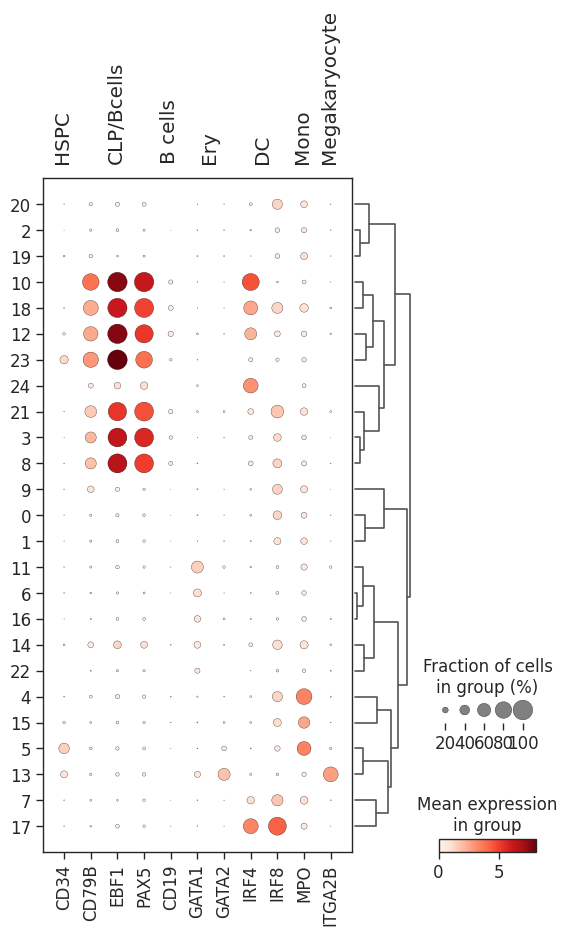

In [73]:
sc.pl.dotplot(ad, markers, 'phenograph', dendrogram = True)

In [63]:
imp_df = pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                                                index=ad.obs_names, columns=ad.var_names)



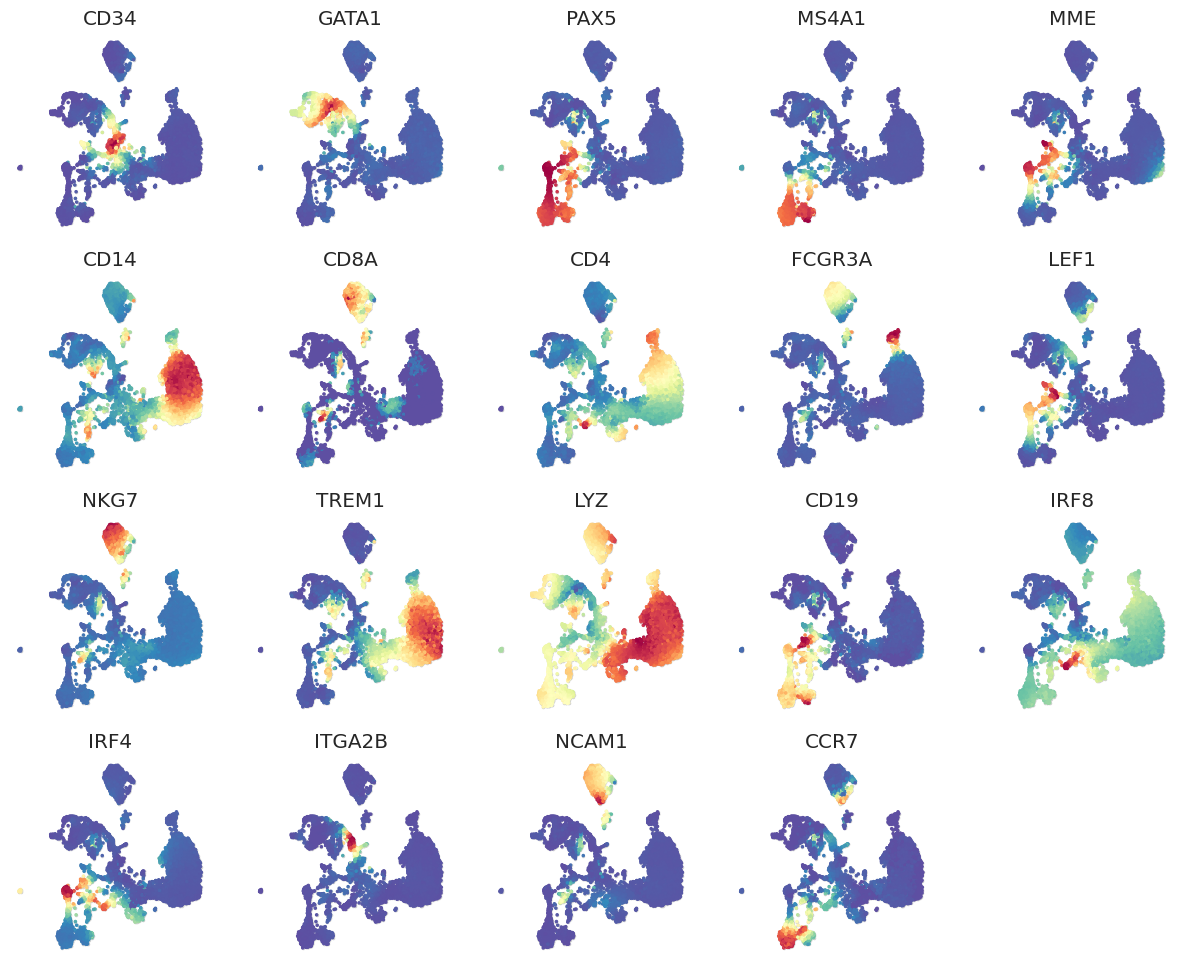

In [64]:
palantir.plot.plot_gene_expression(imp_df,
                                   pd.DataFrame(ad.obsm['X_umap'], 
                                               index=ad.obs_names, columns=['x', 'y']), 
                                   genes)

In [103]:
cell_types = pd.Series("", index = ad.obs['phenograph'].values.categories)
cell_types[0] = "Mono" # monoPre?
cell_types[1] = "Mono"
cell_types[2] = "Tcell" #these seem to be some sort of Tcell?
cell_types[3] = "BcellTraj"
cell_types[4] = "MonoPre"
cell_types[5] = "HPSC"
cell_types[6] = 'EryPre'
cell_types[7] = "MonoPre" #seems to contain some PDCs or doublets?
cell_types[8] = "BcellTraj"
cell_types[9] = "Mono2" #check this
cell_types[10] = "BcellPre"
cell_types[11] = "EryPre"
cell_types[12] = 'BcellPre'
cell_types[13] = 'MEP' # high megakaryocyte marker expression
cell_types[14] = "Doublets"#not sure what this is, high CD14, GATA1, some IRF8 + CD4 possibly doublets
cell_types[15] = "MyeloidPre" #early monocyte progenitro
cell_types[16]= "EryPre"
cell_types[17] = "DC"
cell_types[18] = "BcellPre"
cell_types[19] =  "Tcell"
cell_types[20] = "Doublets" #low markers overall, 
cell_types[21] = "Doublets" #could be Bcell but high doublets
cell_types[22] = 'Ery'
cell_types[23] = "BcellTraj"
cell_types[24] = "DC" #these might be doublets?

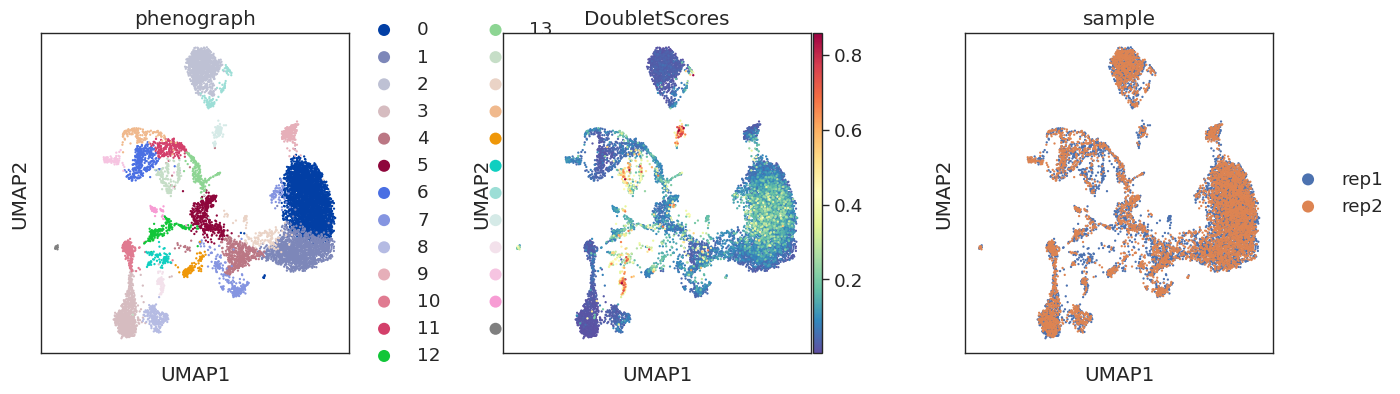

In [104]:
sc.pl.scatter(ad, basis='umap', color=['phenograph', 'DoubletScores', 'sample'])

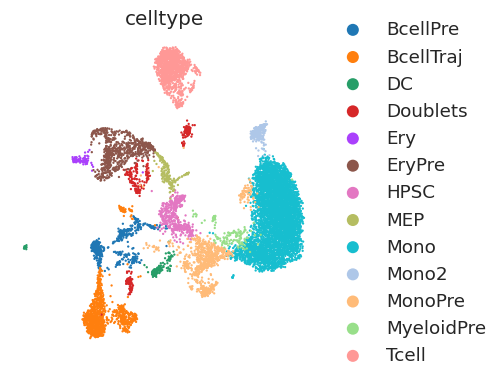

In [135]:
sc.pl.scatter(ad, basis = 'umap', color = 'celltype', frameon = False)

In [109]:
len(ad.obs['celltype'].values.categories)

13

In [113]:
data_dir = os.path.expanduser('/fh/fast/setty_m/user/msetty/projects/sc-density/data/bone-marrow-tcelldep/')

rna_ad_2 = sc.read(data_dir + 'bm_rna_ad.h5ad')

In [115]:
ad.uns['celltype_colors']= rna_ad_2.uns['celltype_combined_colors']

In [118]:
rna_ad_2.obs['celltype_combined'].values.categories

Index(['BcellPre1', 'BcellPre2', 'Bcells', 'CLP', 'Ery', 'EryPre1', 'EryPre2',
       'HMP', 'HSC', 'MEP', 'Mega', 'Mono', 'MonoPre', 'MyeloidPre', 'MylEry',
       'NEW', 'TcellPre', 'cDC', 'pDC'],
      dtype='object')

In [116]:
ad.obs['celltype'] = cell_types[ad.obs['phenograph']].values

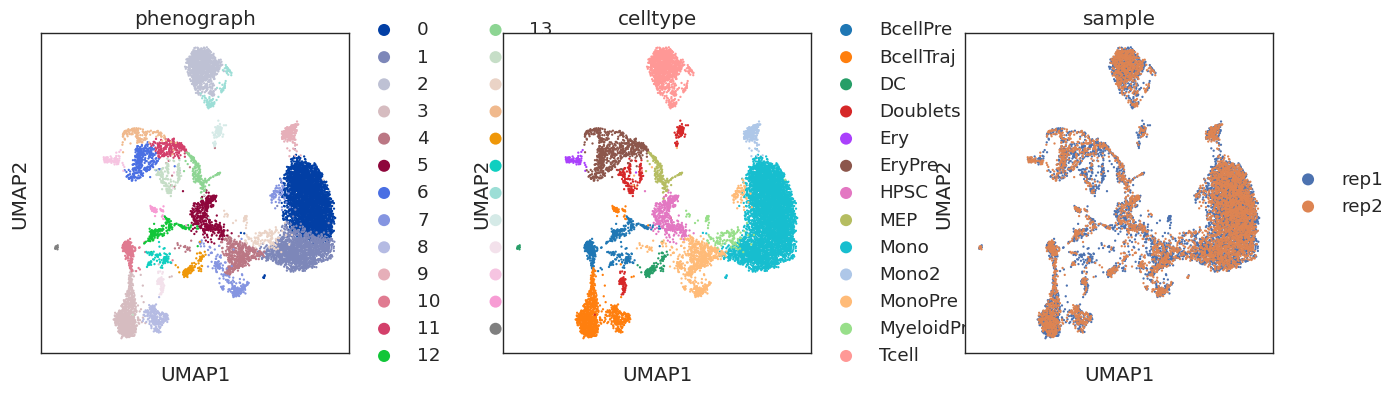

In [117]:
sc.pl.scatter(ad, basis='umap', color=['phenograph', 'celltype', 'sample'])

Cell type annotation can be performed using the same markers listed in https://github.com/settylab/single-cell-primers/blob/main/notebooks/PBMC-RNA-standalone.ipynb

# Save

In [65]:
#temp1 = atac_ad[ad.obs_names, :]
#temp = ad.concatenate(temp1)
#temp.var_names_make_unique()
#temp = temp[:, ad.var_names]

In [119]:
# Attach raw counts
ad.raw = sc.AnnData(raw_ad[ad.obs_names, :][:, ad.var_names].X)

In [125]:
ad.obsm['MAGIC_imputed_data'] = np.asarray(ad.obsm['MAGIC_imputed_data'])

In [127]:
out_dir = '/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/data/'
ad.write(out_dir + 'tcell-dep_multiome_rna_processed.h5ad')

In [129]:
#Export ce/fh/fast/setty_m/user/cjordan2/repositories/ of cells will be use for ATAC analysis
pd.DataFrame(ad.obs_names).to_csv(out_dir + 'tcell-dep_multiome_cells.csv')

In [128]:
ad.obs_names

Index(['tcell-dep-multiome_rep1#AAACAGCCATGAATCT-1',
       'tcell-dep-multiome_rep1#AAACATGCACATAGCC-1',
       'tcell-dep-multiome_rep1#AAACATGCACCTATAG-1',
       'tcell-dep-multiome_rep1#AAACATGCAGGAACTG-1',
       'tcell-dep-multiome_rep1#AAACATGCATAATCAC-1',
       'tcell-dep-multiome_rep1#AAACATGCATAATCCG-1',
       'tcell-dep-multiome_rep1#AAACATGCATTGCGGT-1',
       'tcell-dep-multiome_rep1#AAACCAACACAGCCTG-1',
       'tcell-dep-multiome_rep1#AAACCGAAGACAAAGT-1',
       'tcell-dep-multiome_rep1#AAACCGAAGATGCCTG-1',
       ...
       'tcell-dep-multiome_rep2#TTTGTCTAGTTTCCTG-1',
       'tcell-dep-multiome_rep2#TTTGTGAAGCTGTCAG-1',
       'tcell-dep-multiome_rep2#TTTGTGAAGGCATTAC-1',
       'tcell-dep-multiome_rep2#TTTGTGAAGGCCATCA-1',
       'tcell-dep-multiome_rep2#TTTGTGAAGGTCCGTA-1',
       'tcell-dep-multiome_rep2#TTTGTGGCAATCCCTT-1',
       'tcell-dep-multiome_rep2#TTTGTGTTCAAACACC-1',
       'tcell-dep-multiome_rep2#TTTGTGTTCATTGTTC-1',
       'tcell-dep-multiome_rep2#TTT